In [68]:
import numpy as np
import pandas as pd 
import json
import string

In [69]:
import nltk

In [70]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicholaskunze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
from nltk.corpus import stopwords

In [72]:
# Functionality for preprocessing the data independent of the training and inference process
class PreprocessingHelper: 

    def __init__(self, labels): 
        self.labels = labels
    
    # Read in data 
    # Produces a dataframe of the form label | inputs
    def read_in_json(self, data_src): 

        f = open(data_src, "r")
        json_data = f.read()
        f.close()

        data = json.loads(json_data)
        df = pd.json_normalize(data['intents'])

        df_sentences = pd.DataFrame({"label": [], "input": []})

        labels = []
        inputs = []
    

        for index, row in df.iterrows(): 
            for sentence in row["input"]:
                labels.append(row["label"])
                inputs.append(sentence)
            
        df_sentences["label"] = labels
        df_sentences["input"] = inputs
    
        return df_sentences

    # Function that encodes labels as One Hot Vectors
    def one_hot_labels(self, sentence): 
        return [1 if sentence == label else 0 for label in self.labels]

        
    # Crate bag of words
    # Expects dataframe of form specified in the upper function 
    def fill_bag_of_words(self,table): 
        vocabulary = []
        for row in table:
            for word in row: 
                vocabulary.append(word)
        return [x for x in set(vocabulary)]

In [73]:
# Functionality for the forward pass 
class ChatBotHelper: 

    def __init__(self, bag_of_words): 
        self.bag_of_words = bag_of_words

    @staticmethod
    def nlp_preprocessing(sentence): 
        stop_words = set(stopwords.words('english'))

        tokens = nltk.word_tokenize(sentence) 

        lowercased_tokens = [token.lower() for token in tokens]
        
        filtered_tokens_stopwords = [token for token in lowercased_tokens if token not in stop_words]

        filtered_tokens = [token for token in filtered_tokens_stopwords if token not in string.punctuation]

        return filtered_tokens
    
    def embed(self, sentence):
        return [1 if word in sentence else 0 for word in self.bag_of_words]

    

In [74]:
# Create Training and Test Set 
preprocessingHelper = PreprocessingHelper(["greeting", "weather", "news", "motivation", "breakfast"])

training_data = preprocessingHelper.read_in_json("Data/training_data.json")

training_data = training_data.sample(frac=1).reset_index(drop=True)

training_data_x, training_data_y = training_data['input'], training_data['label']

training_data_x = training_data_x.apply(lambda x: ChatBotHelper.nlp_preprocessing(x))


bag_of_words = preprocessingHelper.fill_bag_of_words(training_data_x)

chatbotHelper = ChatBotHelper(bag_of_words)

X_train = np.array(training_data_x.apply(lambda x: chatbotHelper.embed(x)).tolist())
y_train = np.array(training_data_y.apply(lambda x: preprocessingHelper.one_hot_labels(x)).tolist())


In [75]:
test_data = preprocessingHelper.read_in_json("Data/test_data.json")

test_data_x, test_data_y = test_data['input'], test_data['label']

test_data_x = test_data_x.apply(lambda x: ChatBotHelper.nlp_preprocessing(x))

X_test = np.array(test_data_x.apply(lambda x: chatbotHelper.embed(x)).tolist())
y_test = np.array(test_data_y.apply(lambda x: preprocessingHelper.one_hot_labels(x)).tolist())

In [76]:
# Create basic Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([

    Dense(128, input_dim=98, activation='relu'),  # 128 units, ReLU activation
    
    Dropout(0.5),

    Dense(64, activation='relu'),  # 64 units, ReLU activation
    
    Dense(5, activation='softmax')  # Output layer with softmax for classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=15)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1942 - loss: 1.6012  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2644 - loss: 1.5807
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2511 - loss: 1.5673
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4222 - loss: 1.5325
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4702 - loss: 1.4835
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6204 - loss: 1.4609
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5880 - loss: 1.4304
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6711 - loss: 1.4043
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6449 - loss: 1.3749
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7049 - loss: 1.3949
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6871 - loss: 1.3142
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 1.2765
Epoch 13/50

In [77]:
model.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6800 - loss: 0.6890


[0.6889844536781311, 0.6800000071525574]

In [78]:
# Analyzing the error

In [79]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


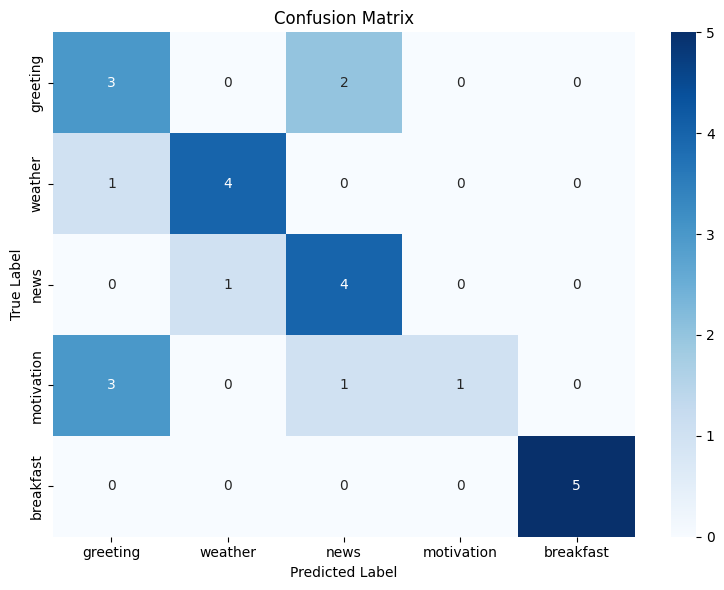

In [80]:
class_labels = ["greeting", "weather", "news", "motivation", "breakfast"]

predictions = np.argmax(model.predict(X_test), axis = 1) 

cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [81]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(np.argmax(y_test, axis=1), predictions, target_names=["greeting", "weather", "news", "motivation", "breakfast"])
print(report)

              precision    recall  f1-score   support

    greeting       0.43      0.60      0.50         5
     weather       0.80      0.80      0.80         5
        news       0.57      0.80      0.67         5
  motivation       1.00      0.20      0.33         5
   breakfast       1.00      1.00      1.00         5

    accuracy                           0.68        25
   macro avg       0.76      0.68      0.66        25
weighted avg       0.76      0.68      0.66        25



In [82]:
#bag_of_words # (Omitted here for maintaining readibility) 

In [83]:
#training_data_x # (Omitted here for maintaining readibility) 

In [84]:
np.sum(X_test, axis=1)

array([1, 2, 1, 0, 1, 3, 1, 2, 3, 2, 1, 3, 2, 3, 2, 2, 1, 2, 0, 1, 3, 5,
       2, 2, 3])

In [85]:
np.sum(X_test, axis=1)

array([1, 2, 1, 0, 1, 3, 1, 2, 3, 2, 1, 3, 2, 3, 2, 2, 1, 2, 0, 1, 3, 5,
       2, 2, 3])

In [86]:
from difflib import SequenceMatcher

# ChatBotHelper extended by the functionality described above 
class ChatBotHelper_Improved: 

    def __init__(self, bag_of_words): 
        self.bag_of_words = bag_of_words
    
    @staticmethod
    def nlp_preprocessing(sentence): 
        stop_words = set(stopwords.words('english'))

        tokens = nltk.word_tokenize(sentence) 

        lowercased_tokens = [token.lower() for token in tokens]
        
        filtered_tokens_stopwords = [token for token in lowercased_tokens if token not in stop_words]

        filtered_tokens = [token for token in filtered_tokens_stopwords if token not in string.punctuation]

        # Remove filler tokens
        filler_filtered_tokens = [token for token in filtered_tokens if token not in ["'","'s", "’"]]

        return filler_filtered_tokens
        
    
    def embed(self, sentence):
        return [1 if word in sentence else 0 for word in self.bag_of_words or lexical_similarity(word, word2)>0.75]

    def lexical_similarity(word1, word2):
        # Ratio of longest common subsequence
        return SequenceMatcher(None, word1, word2).ratio()
        

    

In [87]:
# Mehr Daten für Motivation
def add_data(df):
    new_rows = pd.DataFrame([
        {'label': 'motivation', 'input': 'Give me some words of motivation'}
        
    ])
    return pd.concat([df, new_rows], ignore_index=True)

In [88]:
# Create Training and Test Set 
preprocessingHelper = PreprocessingHelper(["greeting", "weather", "news", "motivation", "breakfast"])

training_data = preprocessingHelper.read_in_json("Data/training_data.json")

training_data = add_data(training_data)

training_data = training_data.sample(frac=1).reset_index(drop=True)

training_data_x, training_data_y = training_data['input'], training_data['label']

training_data_x = training_data_x.apply(lambda x: ChatBotHelper.nlp_preprocessing(x))


bag_of_words = preprocessingHelper.fill_bag_of_words(training_data_x)

chatbotHelper = ChatBotHelper_Improved(bag_of_words)

X_train_improved = np.array(training_data_x.apply(lambda x: chatbotHelper.embed(x)).tolist())
y_train_improved = np.array(training_data_y.apply(lambda x: preprocessingHelper.one_hot_labels(x)).tolist())


In [89]:
test_data = preprocessingHelper.read_in_json("Data/test_data.json")

test_data_x, test_data_y = test_data['input'], test_data['label']

test_data_x = test_data_x.apply(lambda x: ChatBotHelper_Improved.nlp_preprocessing(x))

X_test_improved = np.array(test_data_x.apply(lambda x: chatbotHelper.embed(x)).tolist())
y_test_improved = np.array(test_data_y.apply(lambda x: preprocessingHelper.one_hot_labels(x)).tolist())

In [90]:
# Create Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([

    Dense(128, input_dim=100, activation='relu'),  # 128 units, ReLU activation
    
    Dropout(0.5),

    Dense(64, activation='relu'),  # 64 units, ReLU activation
    
    Dense(5, activation='softmax')  # Output layer with softmax for classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_improved, y_train_improved, epochs=50, batch_size=15)

Epoch 1/50


/Users/nicholaskunze/Desktop/KI Projekte /MorningBriefingAI/morningbriefingai/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1750 - loss: 1.6433  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2061 - loss: 1.5981
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2397 - loss: 1.5900
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2820 - loss: 1.5475
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3790 - loss: 1.5091
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4214 - loss: 1.5107
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5184 - loss: 1.4741
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5295 - loss: 1.4414
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5116 - loss: 1.4184
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5308 - loss: 1.4204
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6288 - loss: 1.3587
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6744 - loss: 1.3474
Epoch 13/50
4/4 ━━━━━━

In [91]:
model.evaluate(X_test_improved,y_test_improved)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8800 - loss: 0.4600


[0.4599955081939697, 0.8799999952316284]

In [93]:
# Hyperparamter Tuning 
# Omitted to prevent overfitting

In [94]:
# Save Model
model.save('chatbot_model.h5', include_optimizer=False)

In [95]:
# Save Bag of Words
with open('vocab.json', 'w') as f:
    json.dump(bag_of_words, f)